# Análisis de errores en MATISSE (6 meses)

Este notebook analiza las observaciones con `ERROR = True` del instrumento
**MATISSE** durante un periodo de 6 meses. El objetivo es caracterizar los
errores más frecuentes, estudiar sus parámetros asociados y aplicar clustering
para detectar agrupaciones o patrones internos dentro de cada `TPL_ID`.


In [2]:
import pandas as pd
import numpy as np
from eliana.datasets import ParlogsObservations
import os
import matplotlib.pyplot as plt

# Importar funciones externalizadas de la carpeta 'src'
from src.preprocesamiento import extract_params, extract_trace_parameters, cargar_y_procesar_carpeta, extract_trace_categoricals,min_max_normalizar
from src.visualizacion import graficos_por_columna
from src.codificacion import codificar_categoricas_por_columna, procesar_strval_in_memory 
from src.clustering import cluster_todos_en_conjunto,plot_clusters_por_cluster_y_origen

plt.style.use('default')
plt.rcParams['font.size'] = 10

## Carga del dataset y filtrado de observaciones con error

Se cargan los parlogs de MATISSE y se extraen:

- `df_meta`: información por observación  
- `df_traces`: información por traza  

Luego se filtran únicamente las observaciones con `ERROR = True`. Estos son
los datos que se analizan en el resto del notebook.


In [3]:
INSTRUMENT='MATISSE'
RANGE='6m'

In [4]:
config = {
    'period': RANGE,
    'system': INSTRUMENT,
    'source': "Instrument",
    'dataset_dir': "../../data"
}
logs = ParlogsObservations(**config)
#logs = ParlogsObservations(period=RANGE, source="Instrument", system=INSTRUMENT)

In [5]:
df_meta = logs.meta
df_meta = df_meta[ df_meta['ERROR'] == True]
df_traces = logs.traces()
df_traces = df_traces[df_traces['trace_id'].isin(df_meta.index)]
TPL_IDs = logs.meta['TPL_ID'].value_counts()

## TPL_ID con mayor número de errores

A partir del dataframe `df_meta` se identifican los `TPL_ID` que presentan
más observaciones con error. Esto permite concentrarse solo en los casos
más representativos y con suficiente cantidad de datos para un análisis
estadístico y de clustering confiable.

Para los análisis posteriores se seleccionan únicamente los `TPL_ID` con
**25 o más errores**.

In [6]:
tpl_counts_err = df_meta['TPL_ID'].value_counts()
print("TPL_ID con errores más frecuentes:")
display(tpl_counts_err.head(10))

TPL_ID con errores más frecuentes:


TPL_ID
MATISSE_gen_tec_ali              67
MATISSE_hyb_obs                  43
MATISSE_img_acq                  39
errseverity                      27
MATISSE_img_acq_ft               23
MATISSE_gen_tec_opd              20
MATISSE_gen_cal_det_aq           15
MATISSE_gen_tec_check_fringes    10
MATISSE_gen_cal_bias              9
MATISSE_gen_cal_imbasic           6
Name: count, dtype: int64

In [7]:
MIN_ERR_POR_TPL = 25

tpl_ids_validos = tpl_counts_err[tpl_counts_err >= MIN_ERR_POR_TPL].index.tolist()
print("TPL_ID usados en TODAS las figuras:", tpl_ids_validos)


TPL_ID usados en TODAS las figuras: ['MATISSE_gen_tec_ali', 'MATISSE_hyb_obs', 'MATISSE_img_acq', 'errseverity']


## Extracción de parámetros numéricos

Para cada `TPL_ID` seleccionado se extraen los parámetros numéricos
asociados a sus trazas. Antes de analizarlos:

- se eliminan parámetros con más del 50% de valores faltantes,  
- se descartan filas con demasiados `NaN`,  
- y se omiten parámetros constantes (sin variación).

El resultado es un conjunto de dataframes limpios (uno por `TPL_ID`)
que contienen únicamente los parámetros útiles para el estudio.


In [8]:
tpl_params_dict_err = {}
threshold_nan = 0.5

for tpl_id in df_meta['TPL_ID'].unique():
    # Solo con error
    params_df_err = extract_trace_parameters(df_meta, df_traces, extract_params, tpl_id=tpl_id)
    if params_df_err is None:
        params_df_err = pd.DataFrame()
    params_df_err = params_df_err.loc[:, params_df_err.isna().mean() < threshold_nan]
    params_df_err = params_df_err.loc[params_df_err.isna().mean(axis=1) < threshold_nan, :]
    if not params_df_err.empty:
        tpl_params_dict_err[tpl_id] = params_df_err

print(f"Se extrajeron parámetros numéricos para {len(tpl_params_dict_err)} TPL_ID con errores.")


Se extrajeron parámetros numéricos para 15 TPL_ID con errores.


## Visualización de parámetros numéricos (histogramas)

Aquí se comparan las distribuciones de los parámetros numéricos entre
observaciones con error y, cuando corresponde, observaciones sin error.

Los histogramas permiten observar:
- desplazamientos entre grupos,
- diferencias de dispersión,
- colas anómalas,
- valores inusualmente repetidos,
- parámetros poco informativos.

Se utiliza escala logarítmica en el eje Y cuando la concentración de datos
es muy alta en valores específicos.


Creando gráficos tipo 'histograma' para 8 parámetros NO constantes...
Figura guardada en: figuras/MATISSE_gen_tec_ali_hist.png


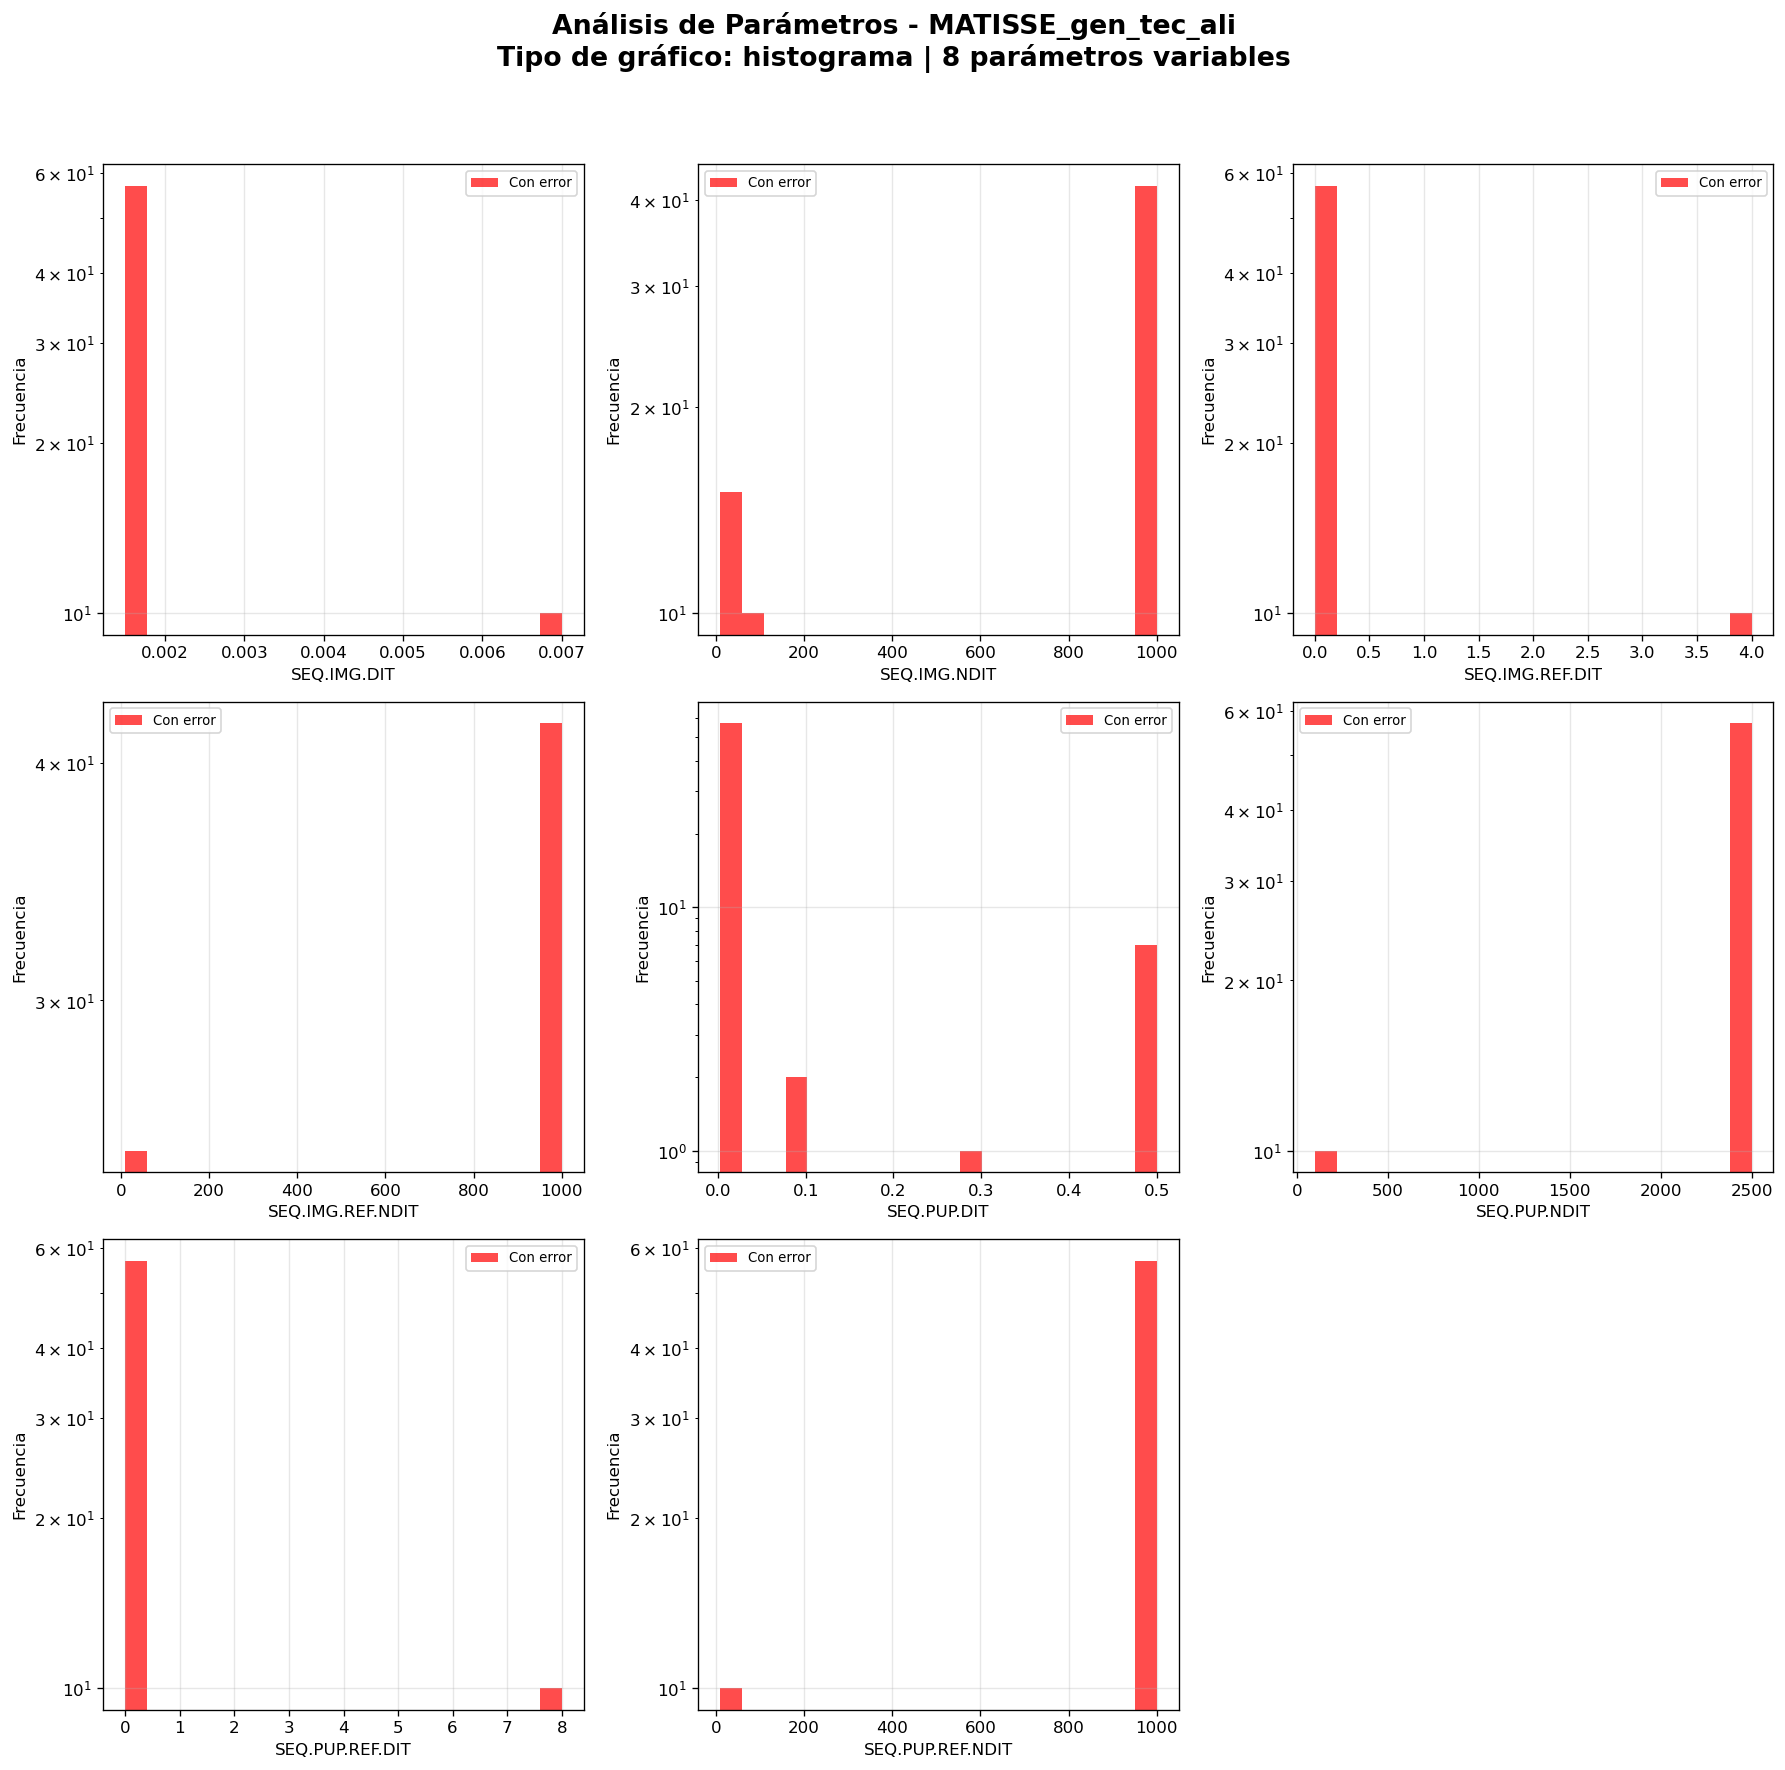

HISTOGRAMA guardado: figuras/MATISSE_gen_tec_ali_hist.png
Creando gráficos tipo 'histograma' para 11 parámetros NO constantes...
Parámetros constantes (omitidos): ['DET1.APOTYPE.VAL', 'DET1.APOX.VAL', 'DET1.APOY.VAL', 'DET1.INTERFX.VAL', 'DET1.INTERFY.VAL', 'DET1.NCOHERENT.VAL', 'DET1.NINCOHERENT.VAL', 'DET1.SNRLIMIT.VAL', 'DET1.WLMINCUT.VAL', 'DET2.APOTYPE.VAL', 'DET2.APOX.VAL', 'DET2.APOY.VAL', 'DET2.INTERFX.VAL', 'DET2.INTERFY.VAL', 'DET2.NCOHERENT.VAL', 'DET2.NINCOHERENT.VAL', 'DET2.SNRLIMIT.VAL', 'DET2.WLMAXCUT.VAL', 'DET2.WLMINCUT.VAL', 'INS.SFL.NAME', 'INS.SFN.NAME', 'SEQ.OPDM.L.WLMAX', 'SEQ.OPDM.N.WLMAX', 'TEL.CHOP.POSANG', 'TEL.CHOP.PVRATIO']
Figura guardada en: figuras/MATISSE_hyb_obs_hist.png


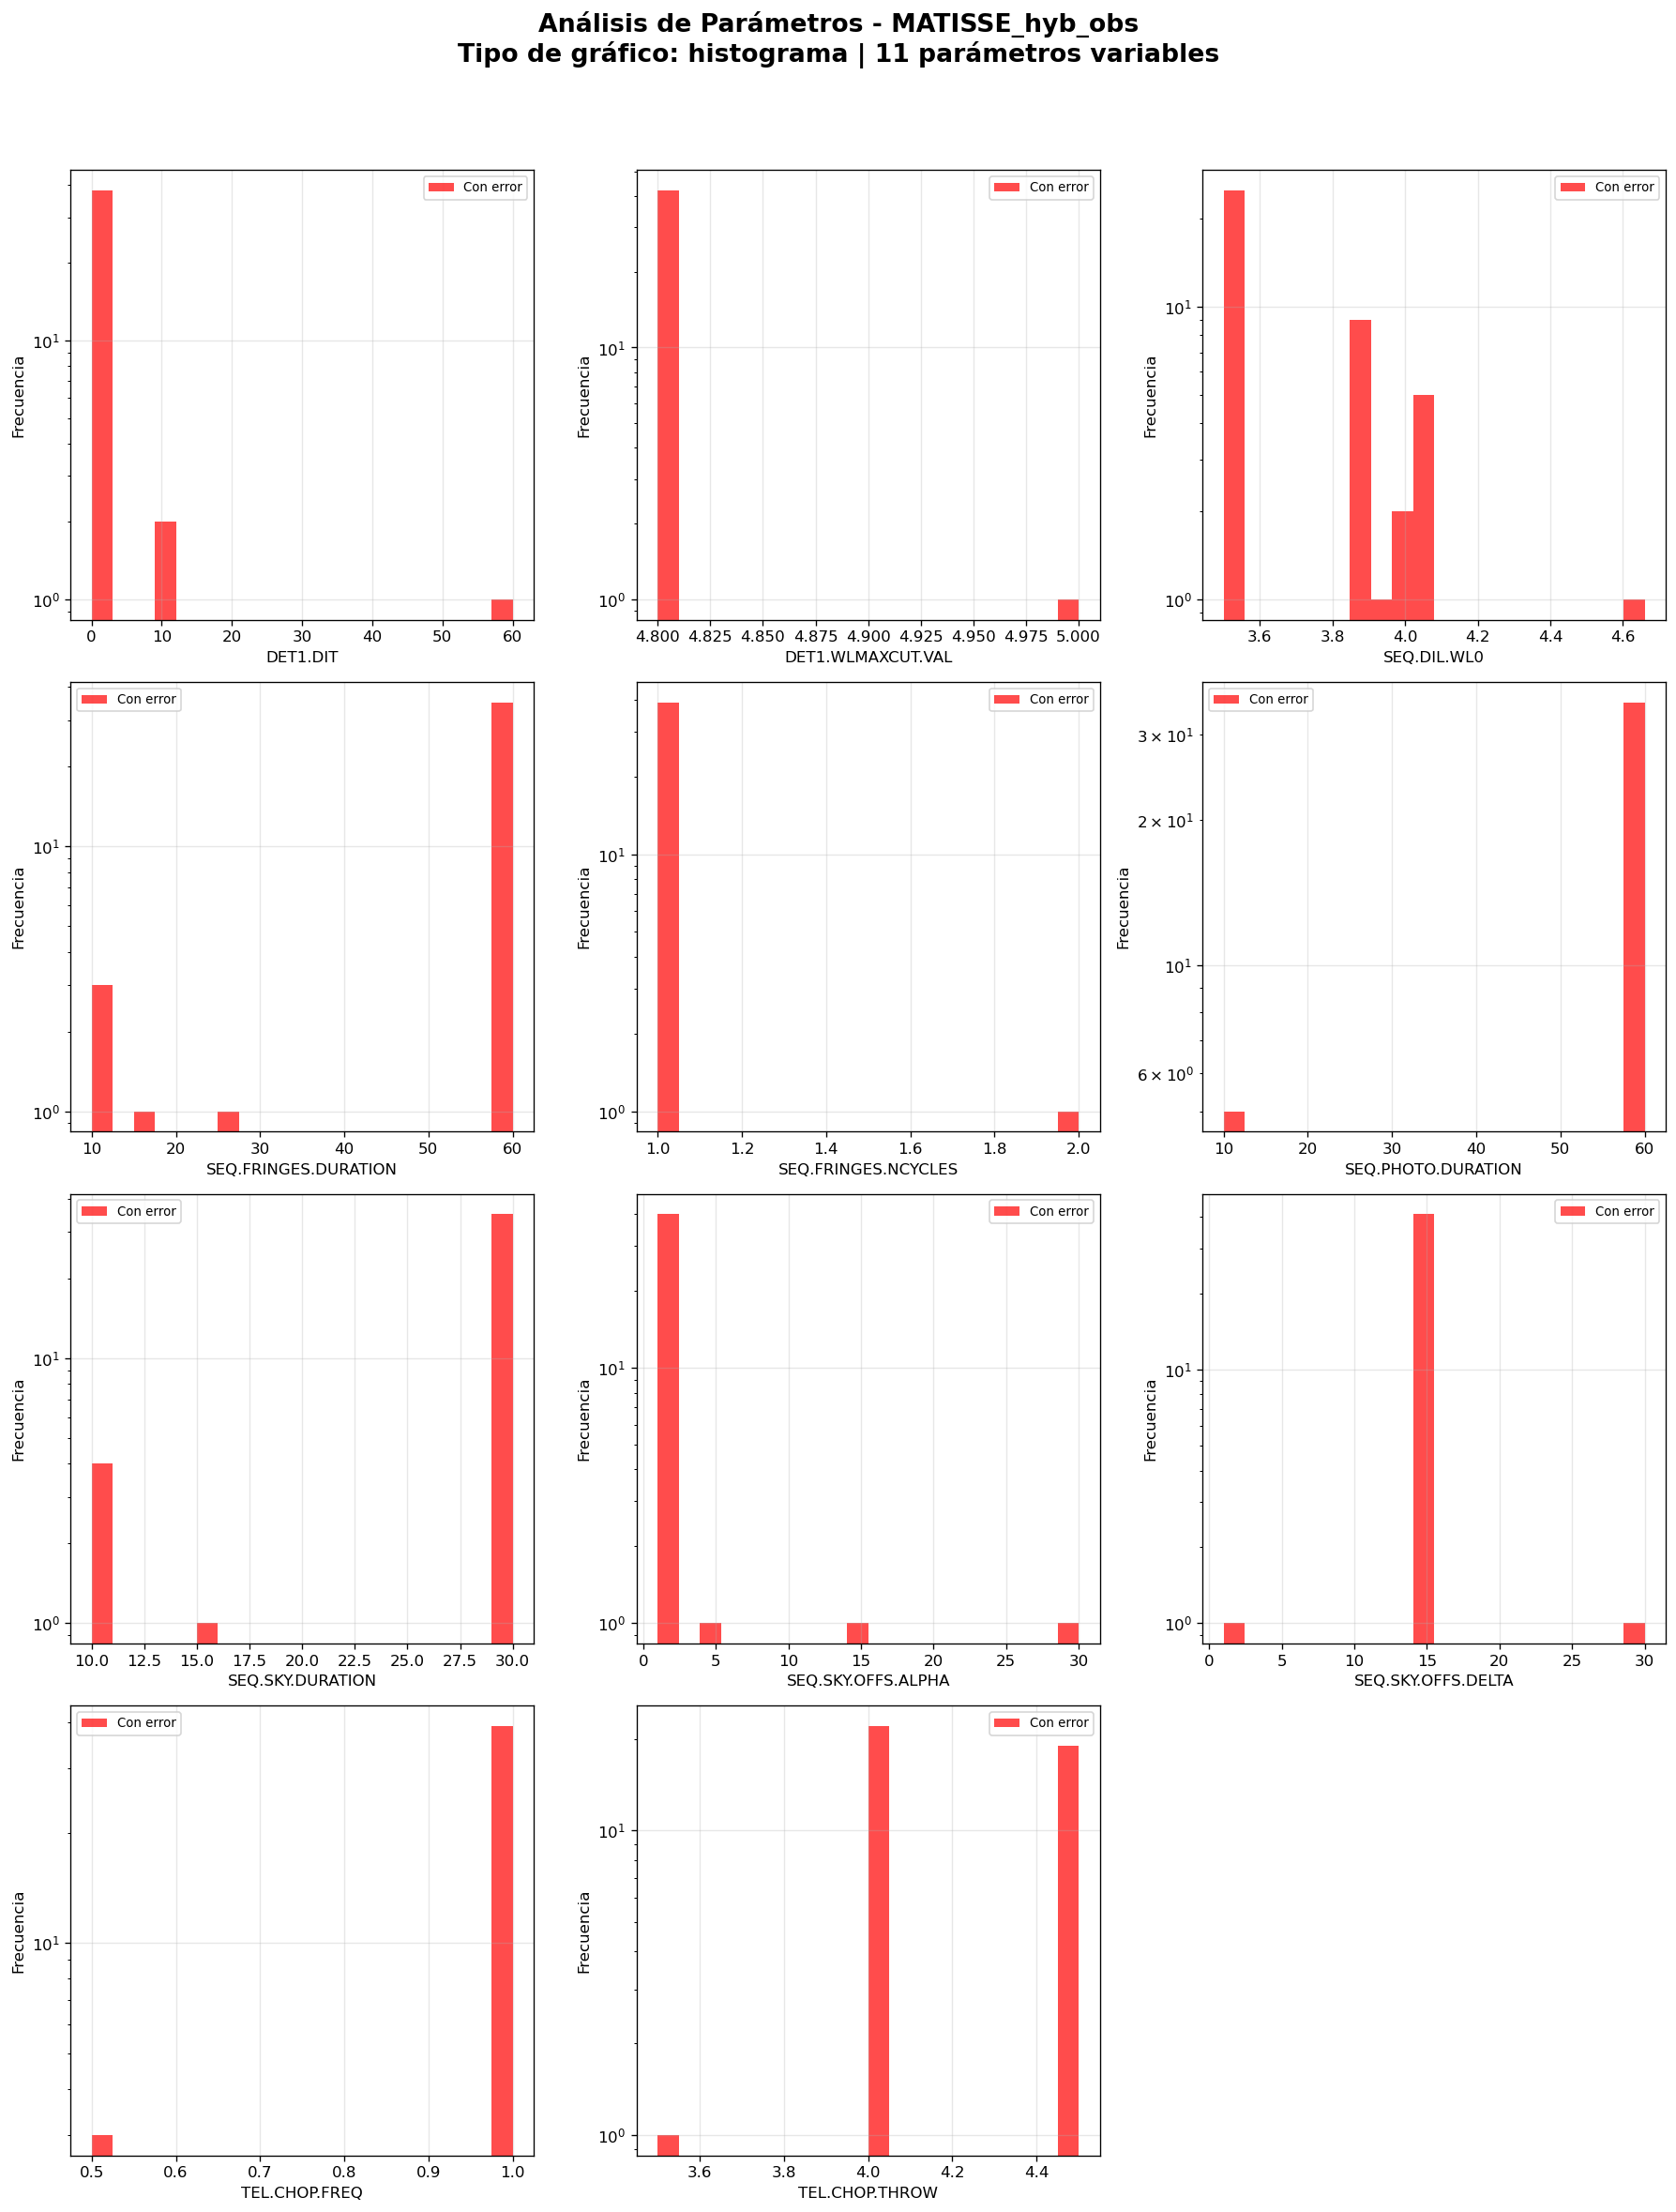

HISTOGRAMA guardado: figuras/MATISSE_hyb_obs_hist.png
Creando gráficos tipo 'histograma' para 17 parámetros NO constantes...
Parámetros constantes (omitidos): ['COU.AG.EPOCH', 'COU.AG.EQUINOX', 'COU.AG.PMA', 'COU.AG.PMD', 'DEL.REF.OPL', 'DET1.APOTYPE.VAL', 'DET1.APOX.VAL', 'DET1.APOY.VAL', 'DET1.INTERFX.VAL', 'DET1.INTERFY.VAL', 'DET1.NCOHERENT.VAL', 'DET1.NINCOHERENT.VAL', 'DET1.SNRLIMIT.VAL', 'DET1.WLMINCUT.VAL', 'DET2.APOTYPE.VAL', 'DET2.APOX.VAL', 'DET2.APOY.VAL', 'DET2.INTERFX.VAL', 'DET2.INTERFY.VAL', 'DET2.NCOHERENT.VAL', 'DET2.NINCOHERENT.VAL', 'DET2.SNRLIMIT.VAL', 'DET2.WLMAXCUT.VAL', 'DET2.WLMINCUT.VAL', 'SEQ.ACQ.SKY.DURATION', 'SEQ.ACQ.TARG.DURATION', 'SEQ.DIL.WL0', 'SEQ.FS.INS.SFL.NAME', 'SEQ.FS.INS.SFN.NAME', 'SEQ.FS.SKY.DURATION', 'SEQ.FS.TARG.DURATION', 'SEQ.OPDM.L.WLMAX', 'SEQ.OPDM.N.WLMAX', 'SEQ.PUP.SKY.DURATION', 'SEQ.PUP.TARG.DURATION', 'SEQ.SKY.OFFS.ALPHA', 'SEQ.SKY.OFFS.DELTA', 'TEL.CHOP.POSANG', 'TEL.CHOP.PVRATIO', 'TEL.GS1.ALPHA', 'TEL.GS1.DELTA', 'TEL.GS1.MAG', 

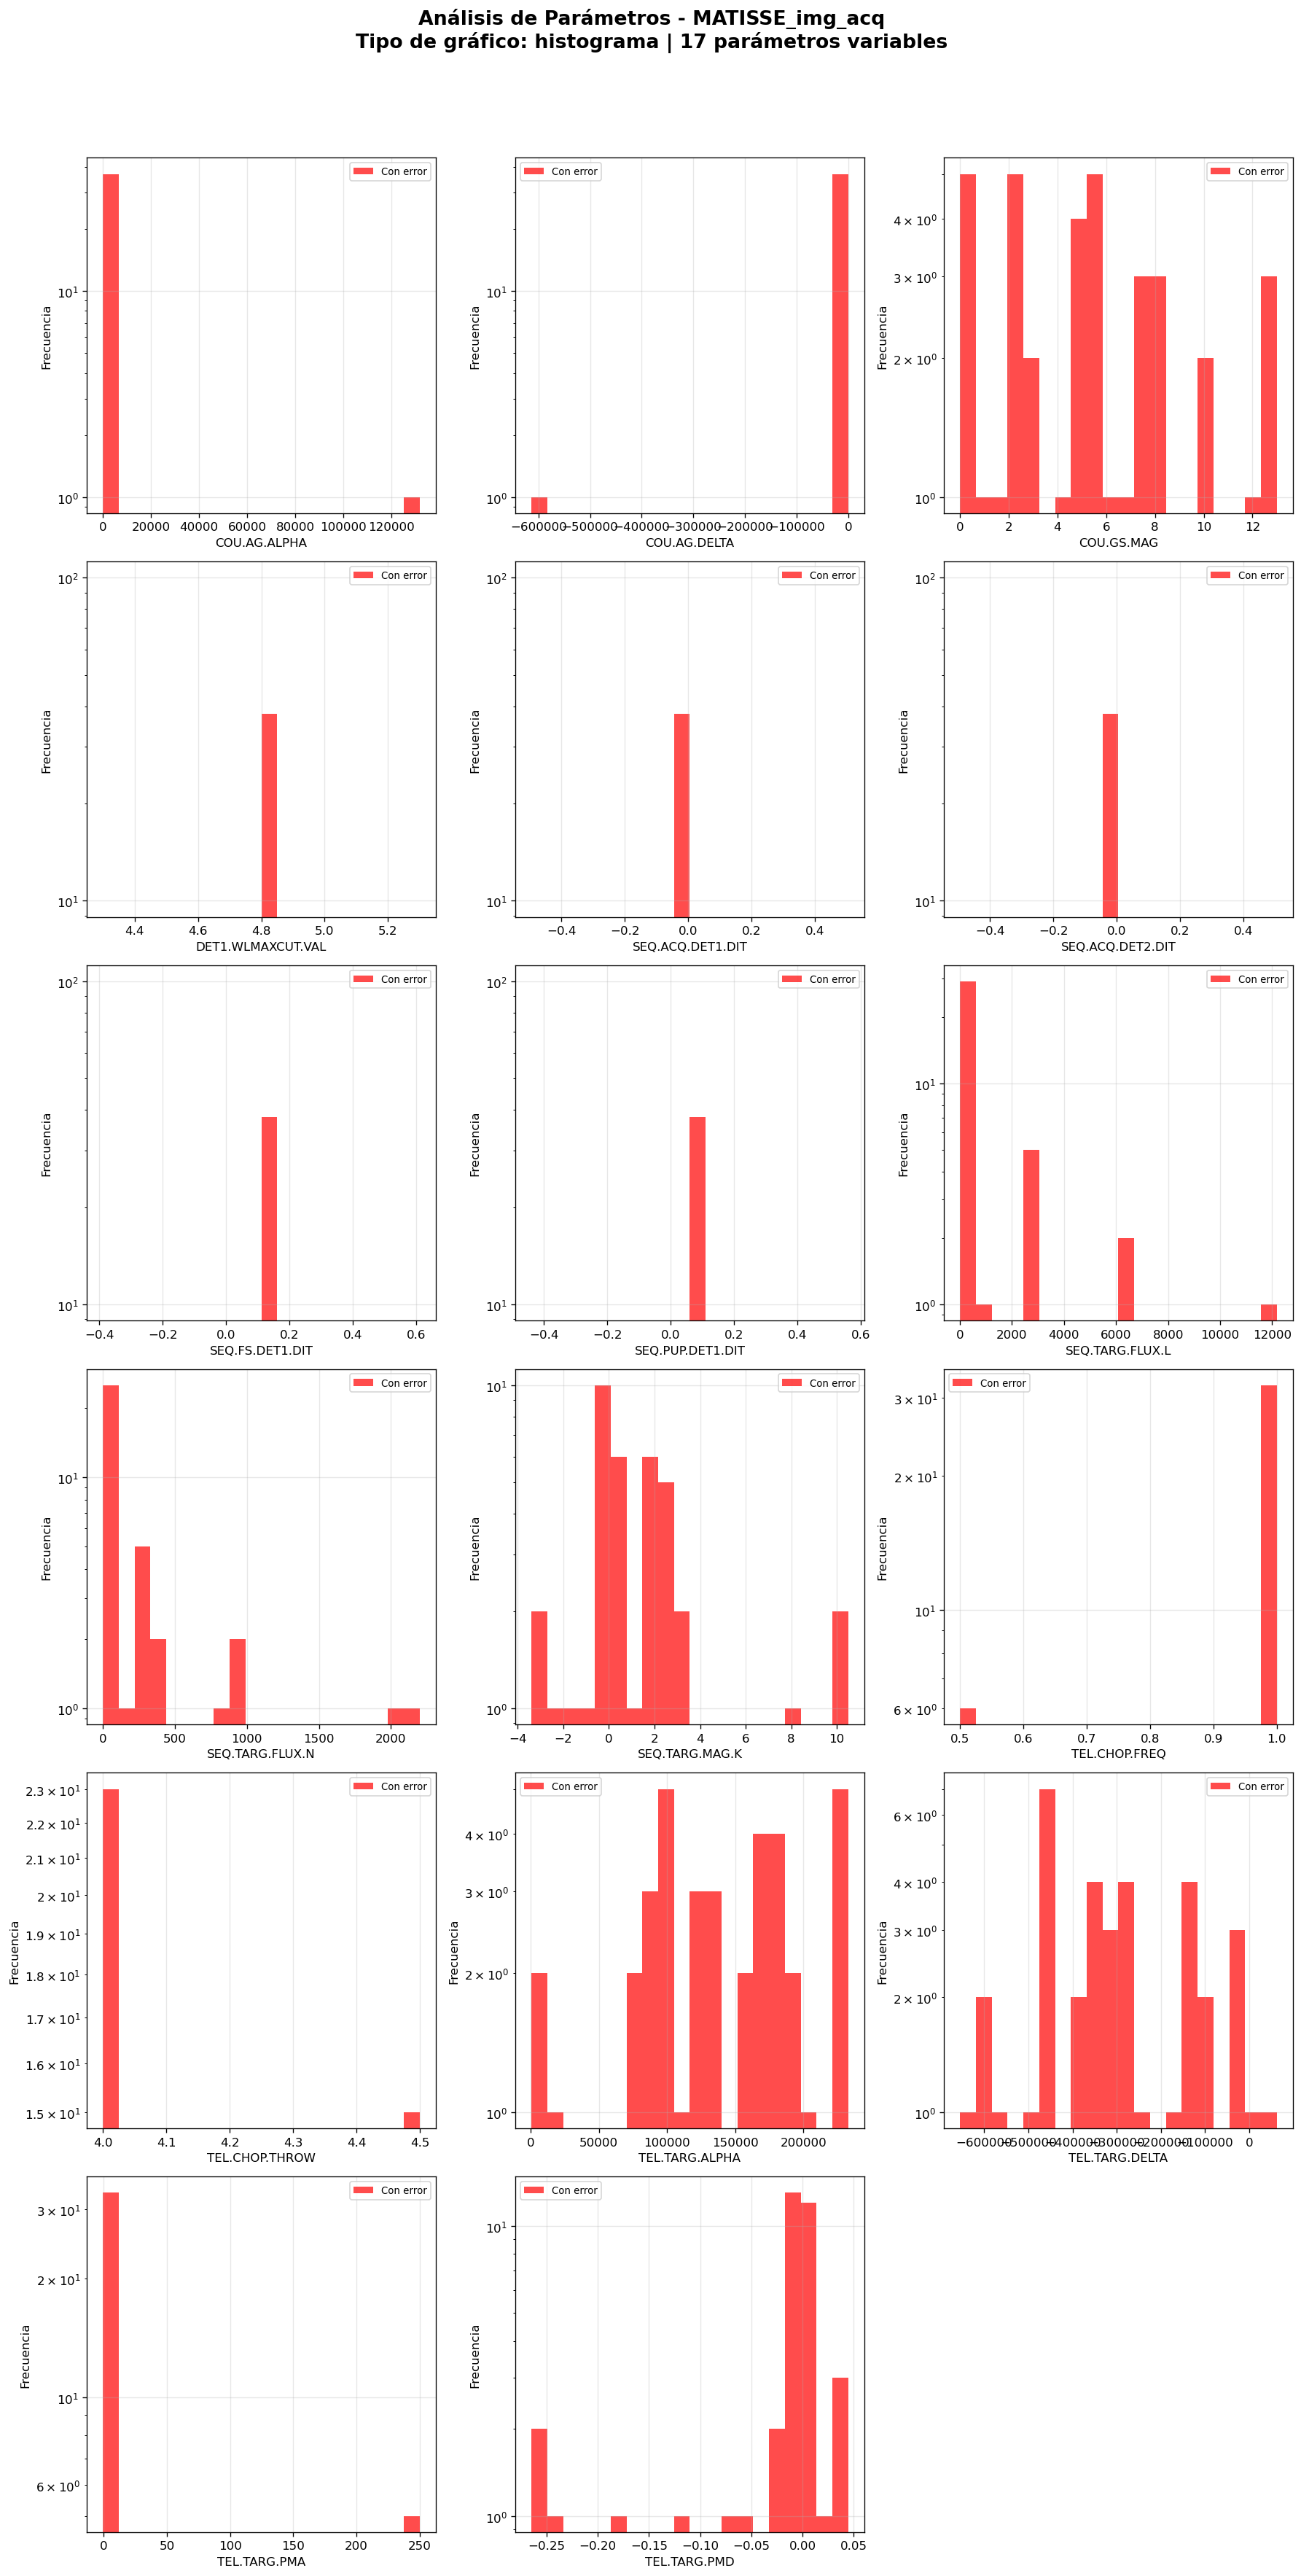

HISTOGRAMA guardado: figuras/MATISSE_img_acq_hist.png
Creando gráficos tipo 'histograma' para 4 parámetros NO constantes...
Parámetros constantes (omitidos): ['DET1.APOTYPE.VAL', 'DET1.APOX.VAL', 'DET1.APOY.VAL', 'DET1.INTERFX.VAL', 'DET1.INTERFY.VAL', 'DET1.NCOHERENT.VAL', 'DET1.NDIT', 'DET1.NINCOHERENT.VAL', 'DET1.SNRLIMIT.VAL', 'DET2.APOTYPE.VAL', 'DET2.APOX.VAL', 'DET2.APOY.VAL', 'DET2.DIT', 'DET2.INTERFX.VAL', 'DET2.INTERFY.VAL', 'DET2.NCOHERENT.VAL', 'DET2.NDIT', 'DET2.NINCOHERENT.VAL', 'DET2.SNRLIMIT.VAL', 'DET2.WLMAXCUT.VAL', 'DET2.WLMINCUT.VAL', 'INS.SFL.NAME', 'INS.SFN.NAME']
Figura guardada en: figuras/errseverity_hist.png


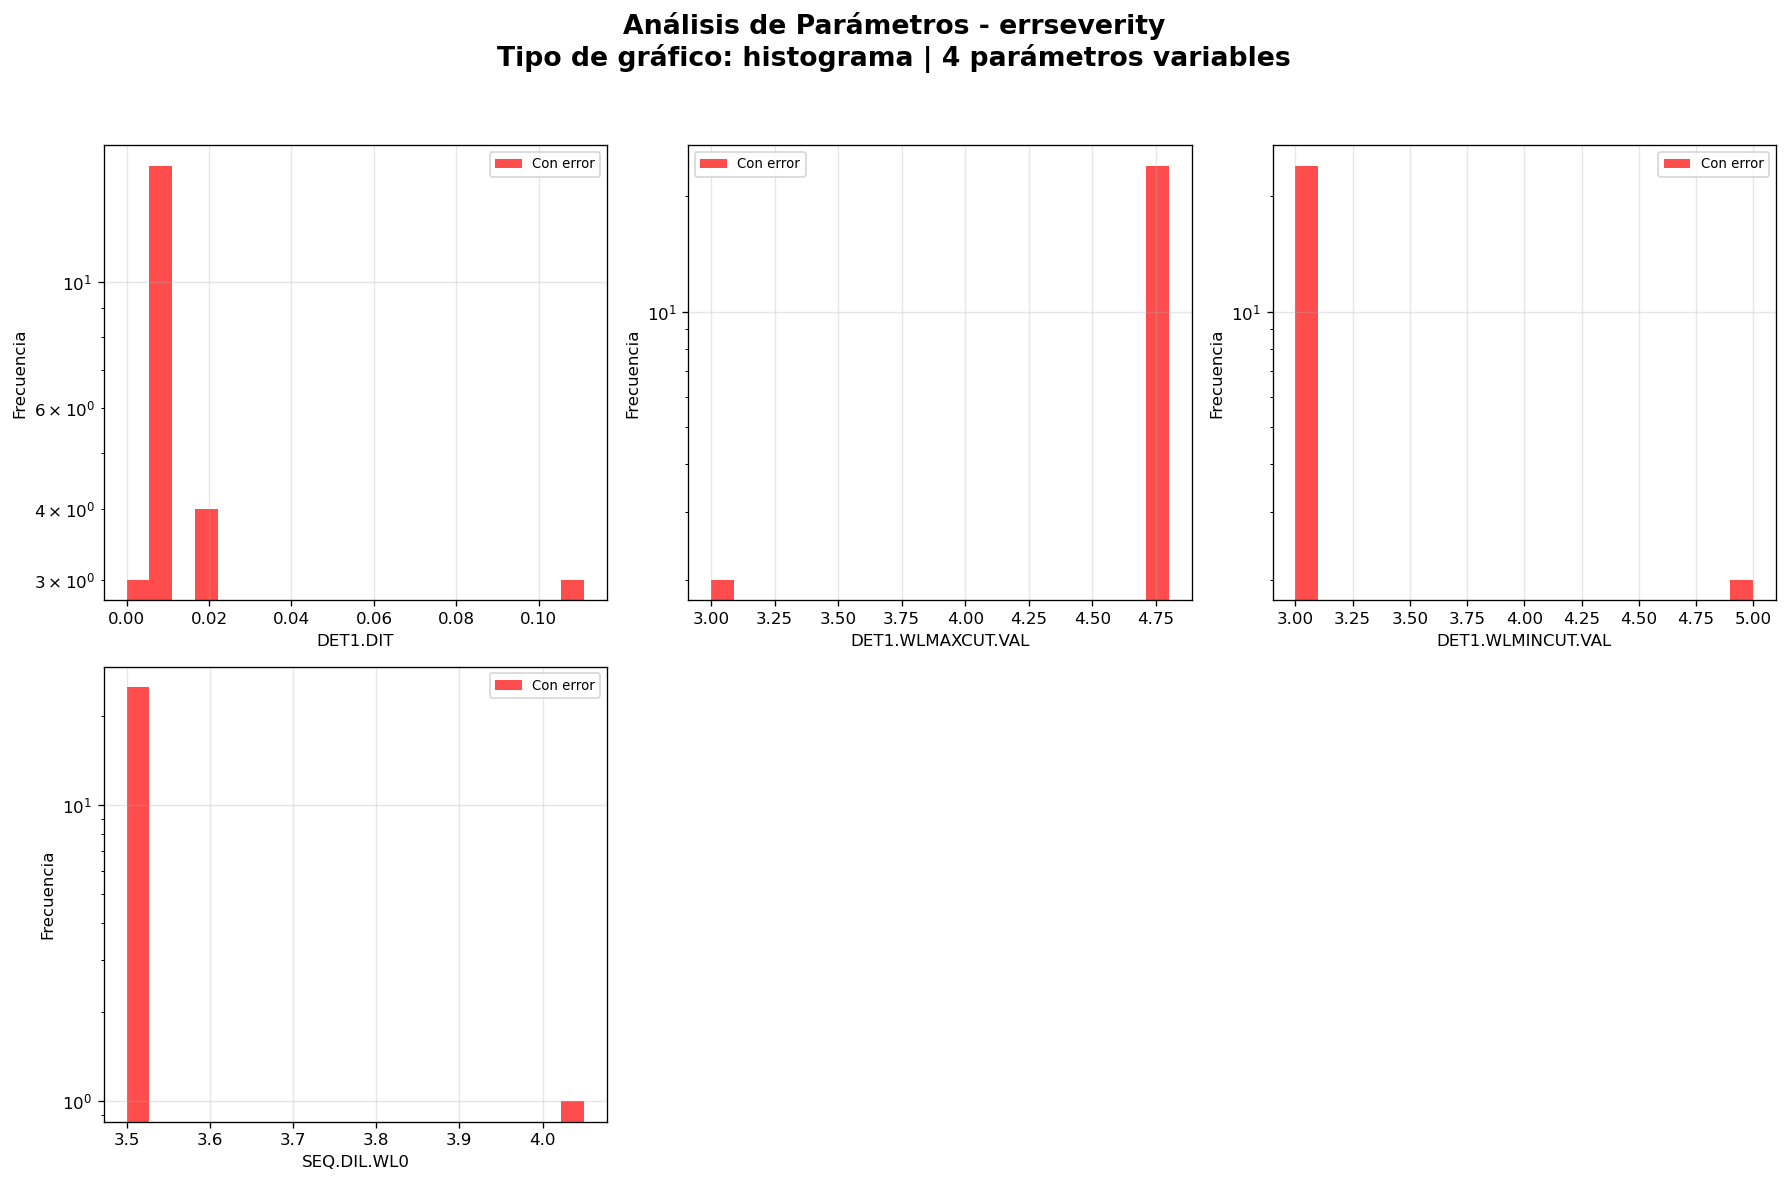

HISTOGRAMA guardado: figuras/errseverity_hist.png


In [9]:
CARPETA_FIG = "figuras"

for tpl_id_str in tpl_ids_validos:
    df_err = tpl_params_dict_err.get(tpl_id_str)

    if df_err is None or df_err.empty:
        print(f"{tpl_id_str}: DataFrame vacío. Se omite HISTOGRAMA.")
        continue

    df_err_num = df_err.apply(pd.to_numeric, errors="coerce")
    cols_num = sorted(df_err_num.select_dtypes(include="number").columns)

    if not cols_num:
        print(f"{tpl_id_str}: No hay columnas numéricas válidas para histograma.")
        continue

    ruta_png = f"{CARPETA_FIG}/{tpl_id_str}_hist.png"

    graficos_por_columna(
        df_sin_error=None,
        df_con_error=df_err_num[cols_num],
        nombre_archivo=tpl_id_str,
        tipo="histograma",
        log_y=True,
        save_path=ruta_png,
        mostrar=True,
    )

    print(f"HISTOGRAMA guardado: {ruta_png}")



## Extracción y análisis de parámetros categóricos

Además de los parámetros numéricos, MATISSE genera un conjunto de
parámetros categóricos asociados a cada traza. Estos se codifican,
limpian y preparan para visualización.

Los parámetros categóricos permiten evaluar si ciertos estados del
instrumento, modos de operación o flags internos aparecen con mayor
frecuencia cuando ocurre un error.


In [10]:
tpl_strval_dict_err = {}

for tpl_id in df_meta['TPL_ID'].unique():
    strval_df_err = extract_trace_categoricals(
        df_meta,      # ya está filtrado con ERROR==True
        df_traces, 
        extract_params,
        tpl_id=tpl_id
    )

    if strval_df_err is not None and not strval_df_err.empty:
        tpl_strval_dict_err[tpl_id] = strval_df_err

print(f"Se extrajeron parámetros categóricos para {len(tpl_strval_dict_err)} TPL_ID con errores.")


Se extrajeron parámetros categóricos para 15 TPL_ID con errores.


In [11]:
codified_strval_err_dfs, dict_codificacion_err = procesar_strval_in_memory(
    tpl_strval_dict_err
)

print("\nCodificación de categóricas completada (solo errores).")
print(f"TPL_ID procesados: {len(codified_strval_err_dfs)}")



Codificación de categóricas completada (solo errores).
TPL_ID procesados: 15


## Gráficos tipo “pie” para parámetros categóricos

Los parámetros categóricos se visualizan como **gráficos de anillos**:

- **Anillo externo:** observaciones sin error  
- **Anillo interno:** observaciones con error  

Este formato hace visible si ciertas categorías:
- son exclusivas de los errores,
- aumentan drásticamente su frecuencia,
- o se comportan de forma similar en ambos grupos.

Se utiliza `log1p` para equilibrar “categorías gigantes” y evitar que oculten
a categorías con menor frecuencia.


Creando gráficos tipo 'pie' para 5 parámetros NO constantes...
Parámetros constantes (omitidos): ['DPR.CATG', 'DPR.TECH', 'SEQ.IMG.DIT', 'SEQ.IMG.NDIT', 'SEQ.IMG.REF.DIT', 'SEQ.IMG.REF.NDIT', 'SEQ.PUP.DIT', 'SEQ.PUP.NDIT', 'SEQ.PUP.REF.DIT', 'SEQ.PUP.REF.NDIT', 'SEQ.SIMUL.ST']
Figura guardada en: figuras/MATISSE_gen_tec_ali_pie.png


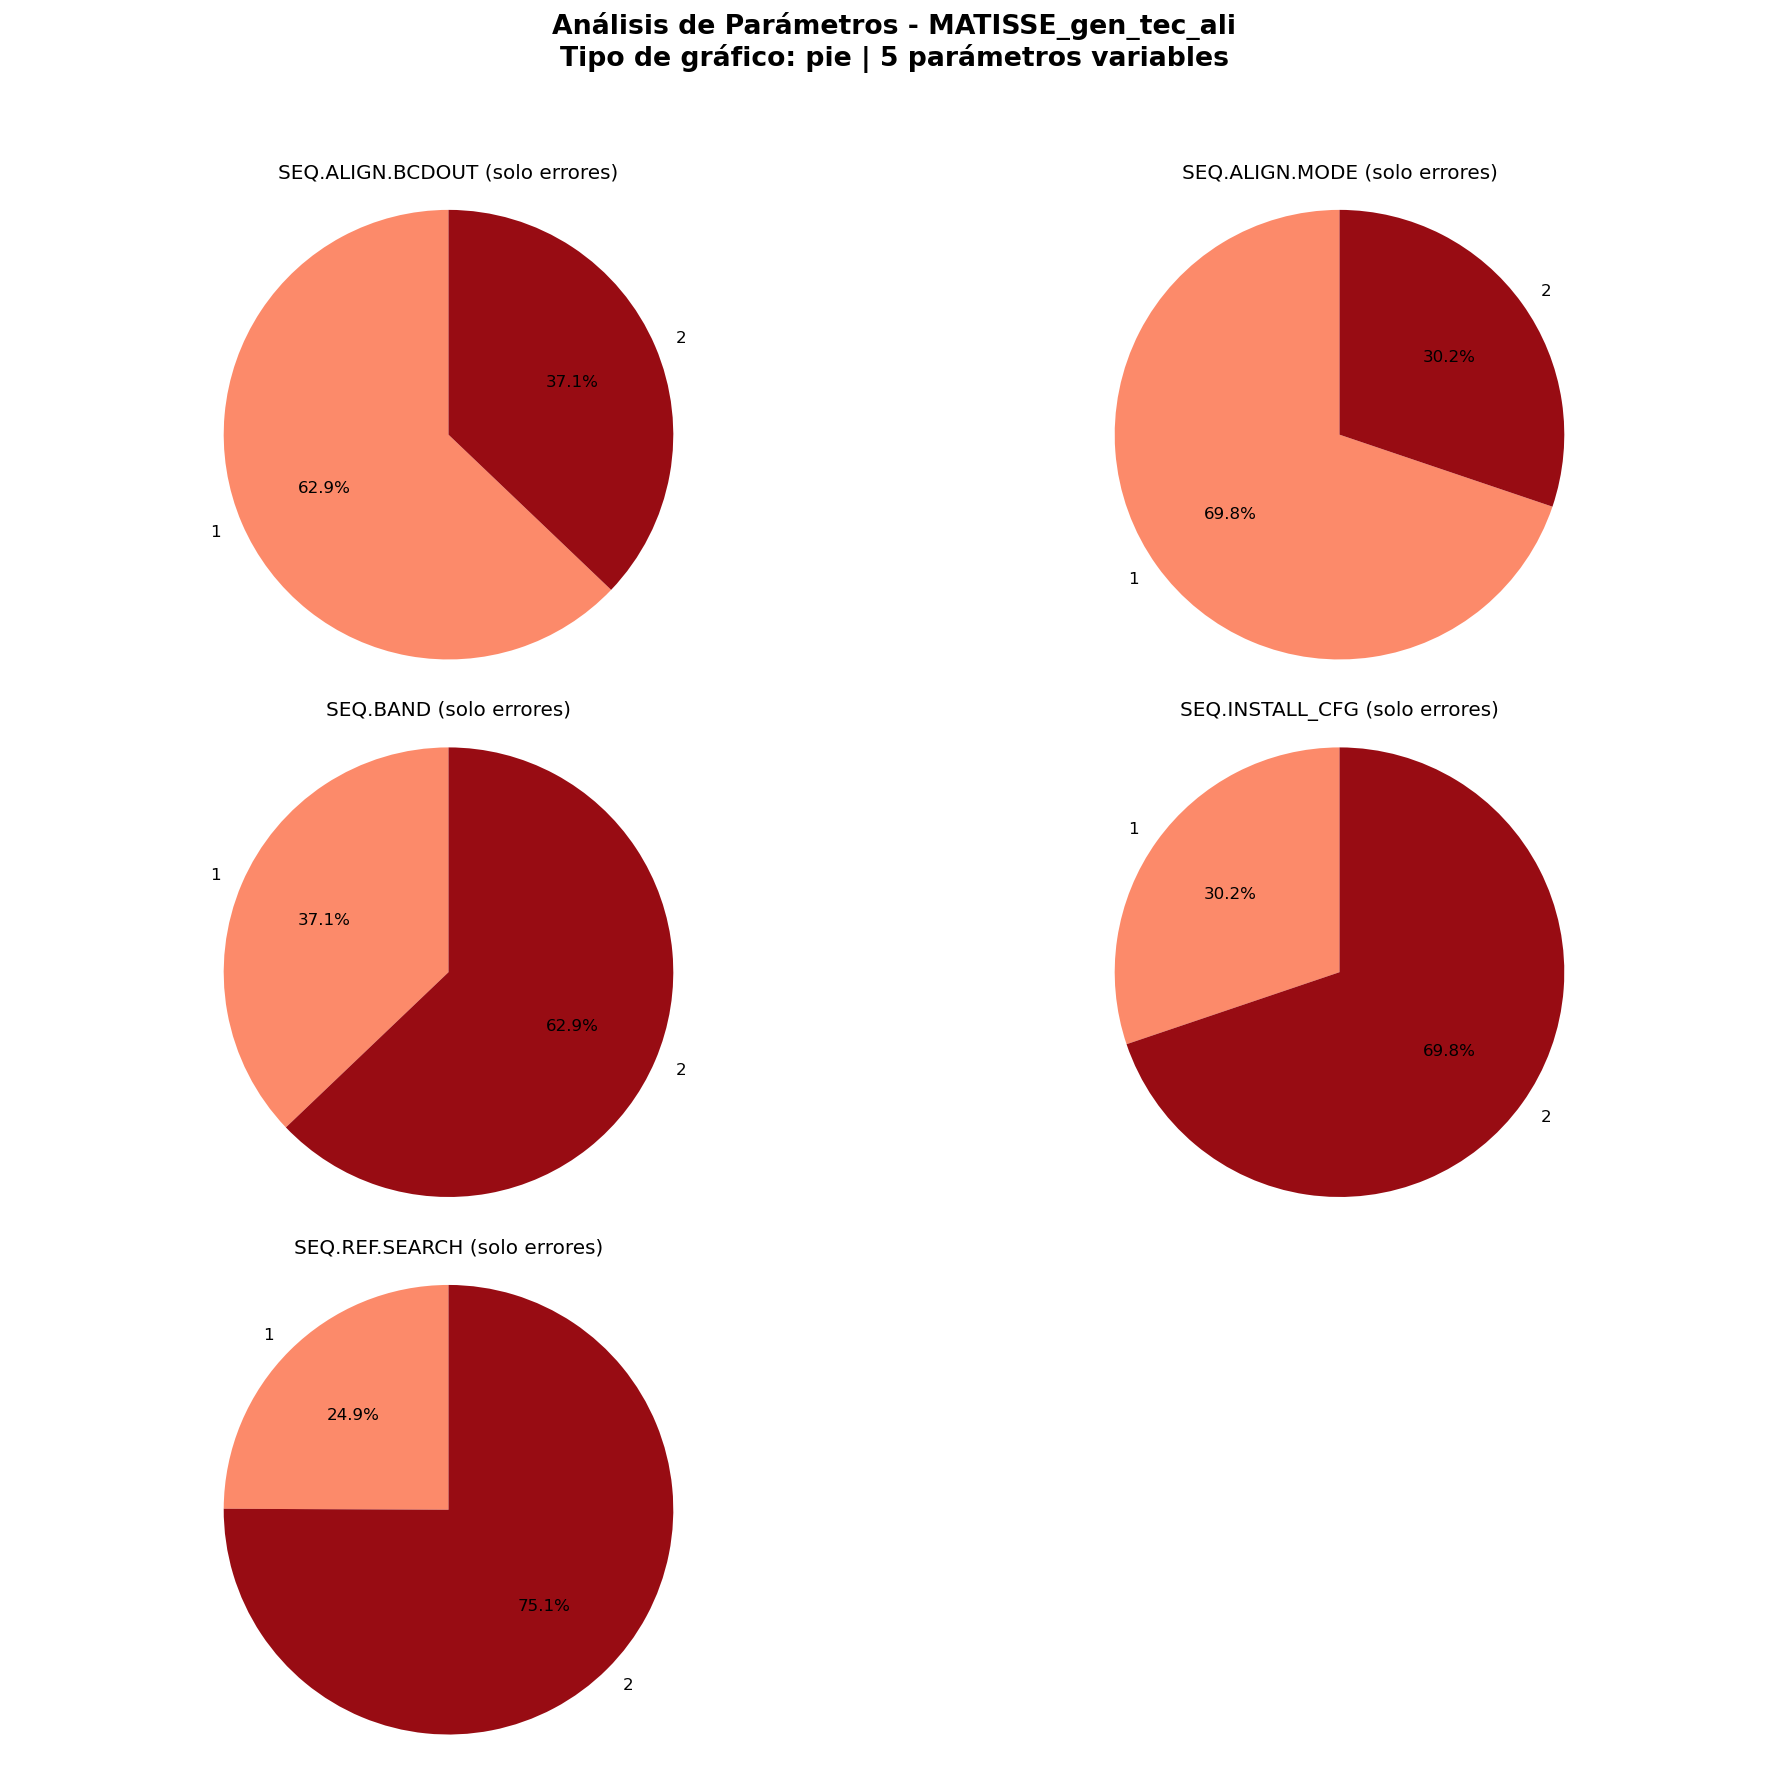

PIE guardado: figuras/MATISSE_gen_tec_ali_pie.png
Creando gráficos tipo 'pie' para 19 parámetros NO constantes...
Parámetros constantes (omitidos): ['DET1.APOTYPE.VAL', 'DET1.APOX.VAL', 'DET1.APOY.VAL', 'DET1.DIT', 'DET1.INTERFX.VAL', 'DET1.INTERFY.VAL', 'DET1.NCOHERENT.VAL', 'DET1.NINCOHERENT.VAL', 'DET1.SNRLIMIT.VAL', 'DET1.WLMAXCUT.VAL', 'DET1.WLMINCUT.VAL', 'DET2.APOTYPE.VAL', 'DET2.APOX.VAL', 'DET2.APOY.VAL', 'DET2.INTERFX.VAL', 'DET2.INTERFY.VAL', 'DET2.NCOHERENT.VAL', 'DET2.NINCOHERENT.VAL', 'DET2.READ.CURNAME', 'DET2.SNRLIMIT.VAL', 'DET2.WLMAXCUT.VAL', 'DET2.WLMINCUT.VAL', 'INS.FIN.NAME', 'INS.POL.NAME', 'INS.PON.NAME', 'INS.SFN.NAME', 'SEQ.DIL.WL0', 'SEQ.FRINGES.DURATION', 'SEQ.FRINGES.NCYCLES', 'SEQ.OPDM.L.WLMAX', 'SEQ.OPDM.N.WLMAX', 'SEQ.PHOTO.DURATION', 'SEQ.RMNREC.ST', 'SEQ.SKY.DURATION', 'SEQ.SKY.OFFS.ALPHA', 'SEQ.SKY.OFFS.DELTA', 'SEQ.TRACK.BAND', 'TEL.CHOP.FREQ', 'TEL.CHOP.POSANG', 'TEL.CHOP.PVRATIO', 'TEL.CHOP.THROW']
Figura guardada en: figuras/MATISSE_hyb_obs_pie.png

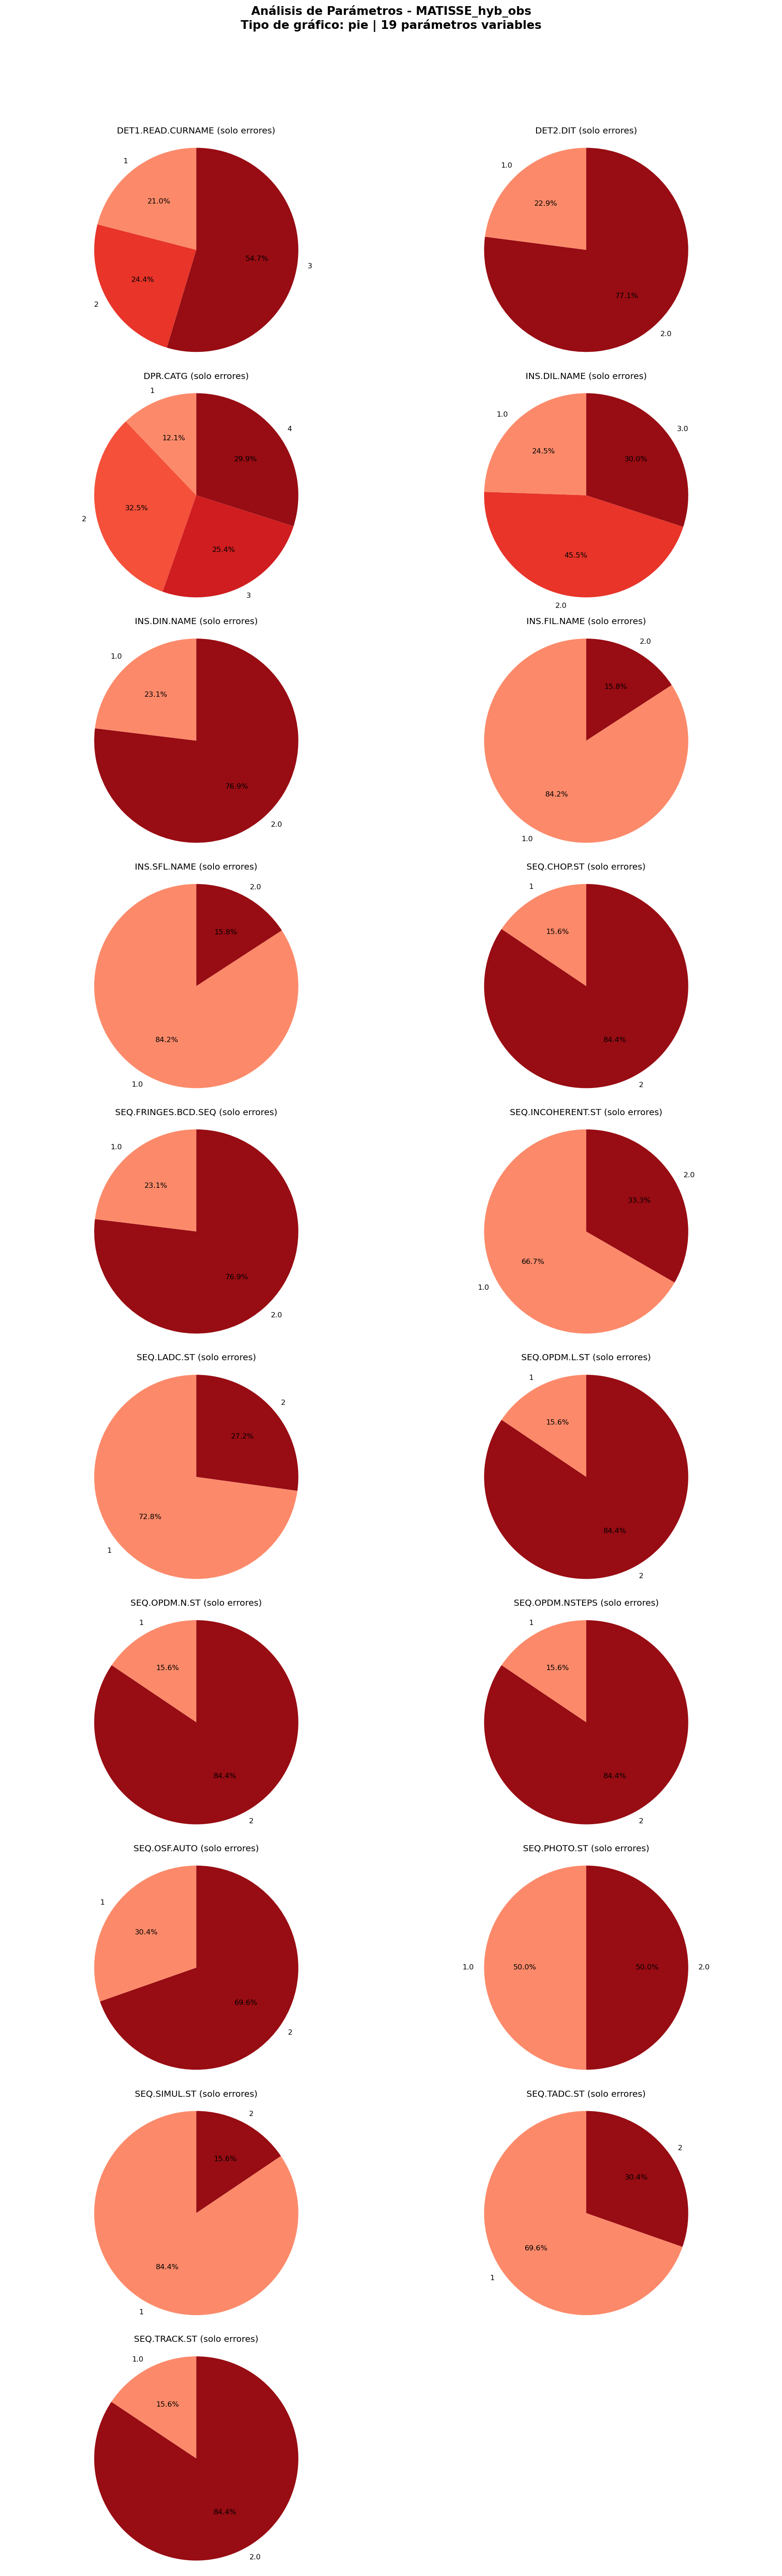

PIE guardado: figuras/MATISSE_hyb_obs_pie.png
Creando gráficos tipo 'pie' para 9 parámetros NO constantes...
Parámetros constantes (omitidos): ['COU.AG.ALPHA', 'COU.AG.DELTA', 'COU.AG.EPOCH', 'COU.AG.EQUINOX', 'COU.AG.GSSOURCE', 'COU.AG.PMA', 'COU.AG.PMD', 'COU.GS.MAG', 'DEL.FT.SENSOR', 'DEL.REF.MODE', 'DEL.REF.NAME', 'DEL.REF.OPL', 'DET1.APOTYPE.VAL', 'DET1.APOX.VAL', 'DET1.APOY.VAL', 'DET1.INTERFX.VAL', 'DET1.INTERFY.VAL', 'DET1.NCOHERENT.VAL', 'DET1.NINCOHERENT.VAL', 'DET1.READ.CURNAME', 'DET1.SNRLIMIT.VAL', 'DET1.WLMAXCUT.VAL', 'DET1.WLMINCUT.VAL', 'DET2.APOTYPE.VAL', 'DET2.APOX.VAL', 'DET2.APOY.VAL', 'DET2.INTERFX.VAL', 'DET2.INTERFY.VAL', 'DET2.NCOHERENT.VAL', 'DET2.NINCOHERENT.VAL', 'DET2.READ.CURNAME', 'DET2.SNRLIMIT.VAL', 'DET2.WLMAXCUT.VAL', 'DET2.WLMINCUT.VAL', 'SEQ.ACQ.DET1.DIT', 'SEQ.ACQ.DET2.DIT', 'SEQ.ACQ.INS.FIL.NAME', 'SEQ.ACQ.INS.FIN.NAME', 'SEQ.ACQ.SKY.DURATION', 'SEQ.ACQ.TARG.DURATION', 'SEQ.DIL.WL0', 'SEQ.FS.DET1.DIT', 'SEQ.FS.DET2.DIT', 'SEQ.FS.INS.DIL.NAME', 'SEQ

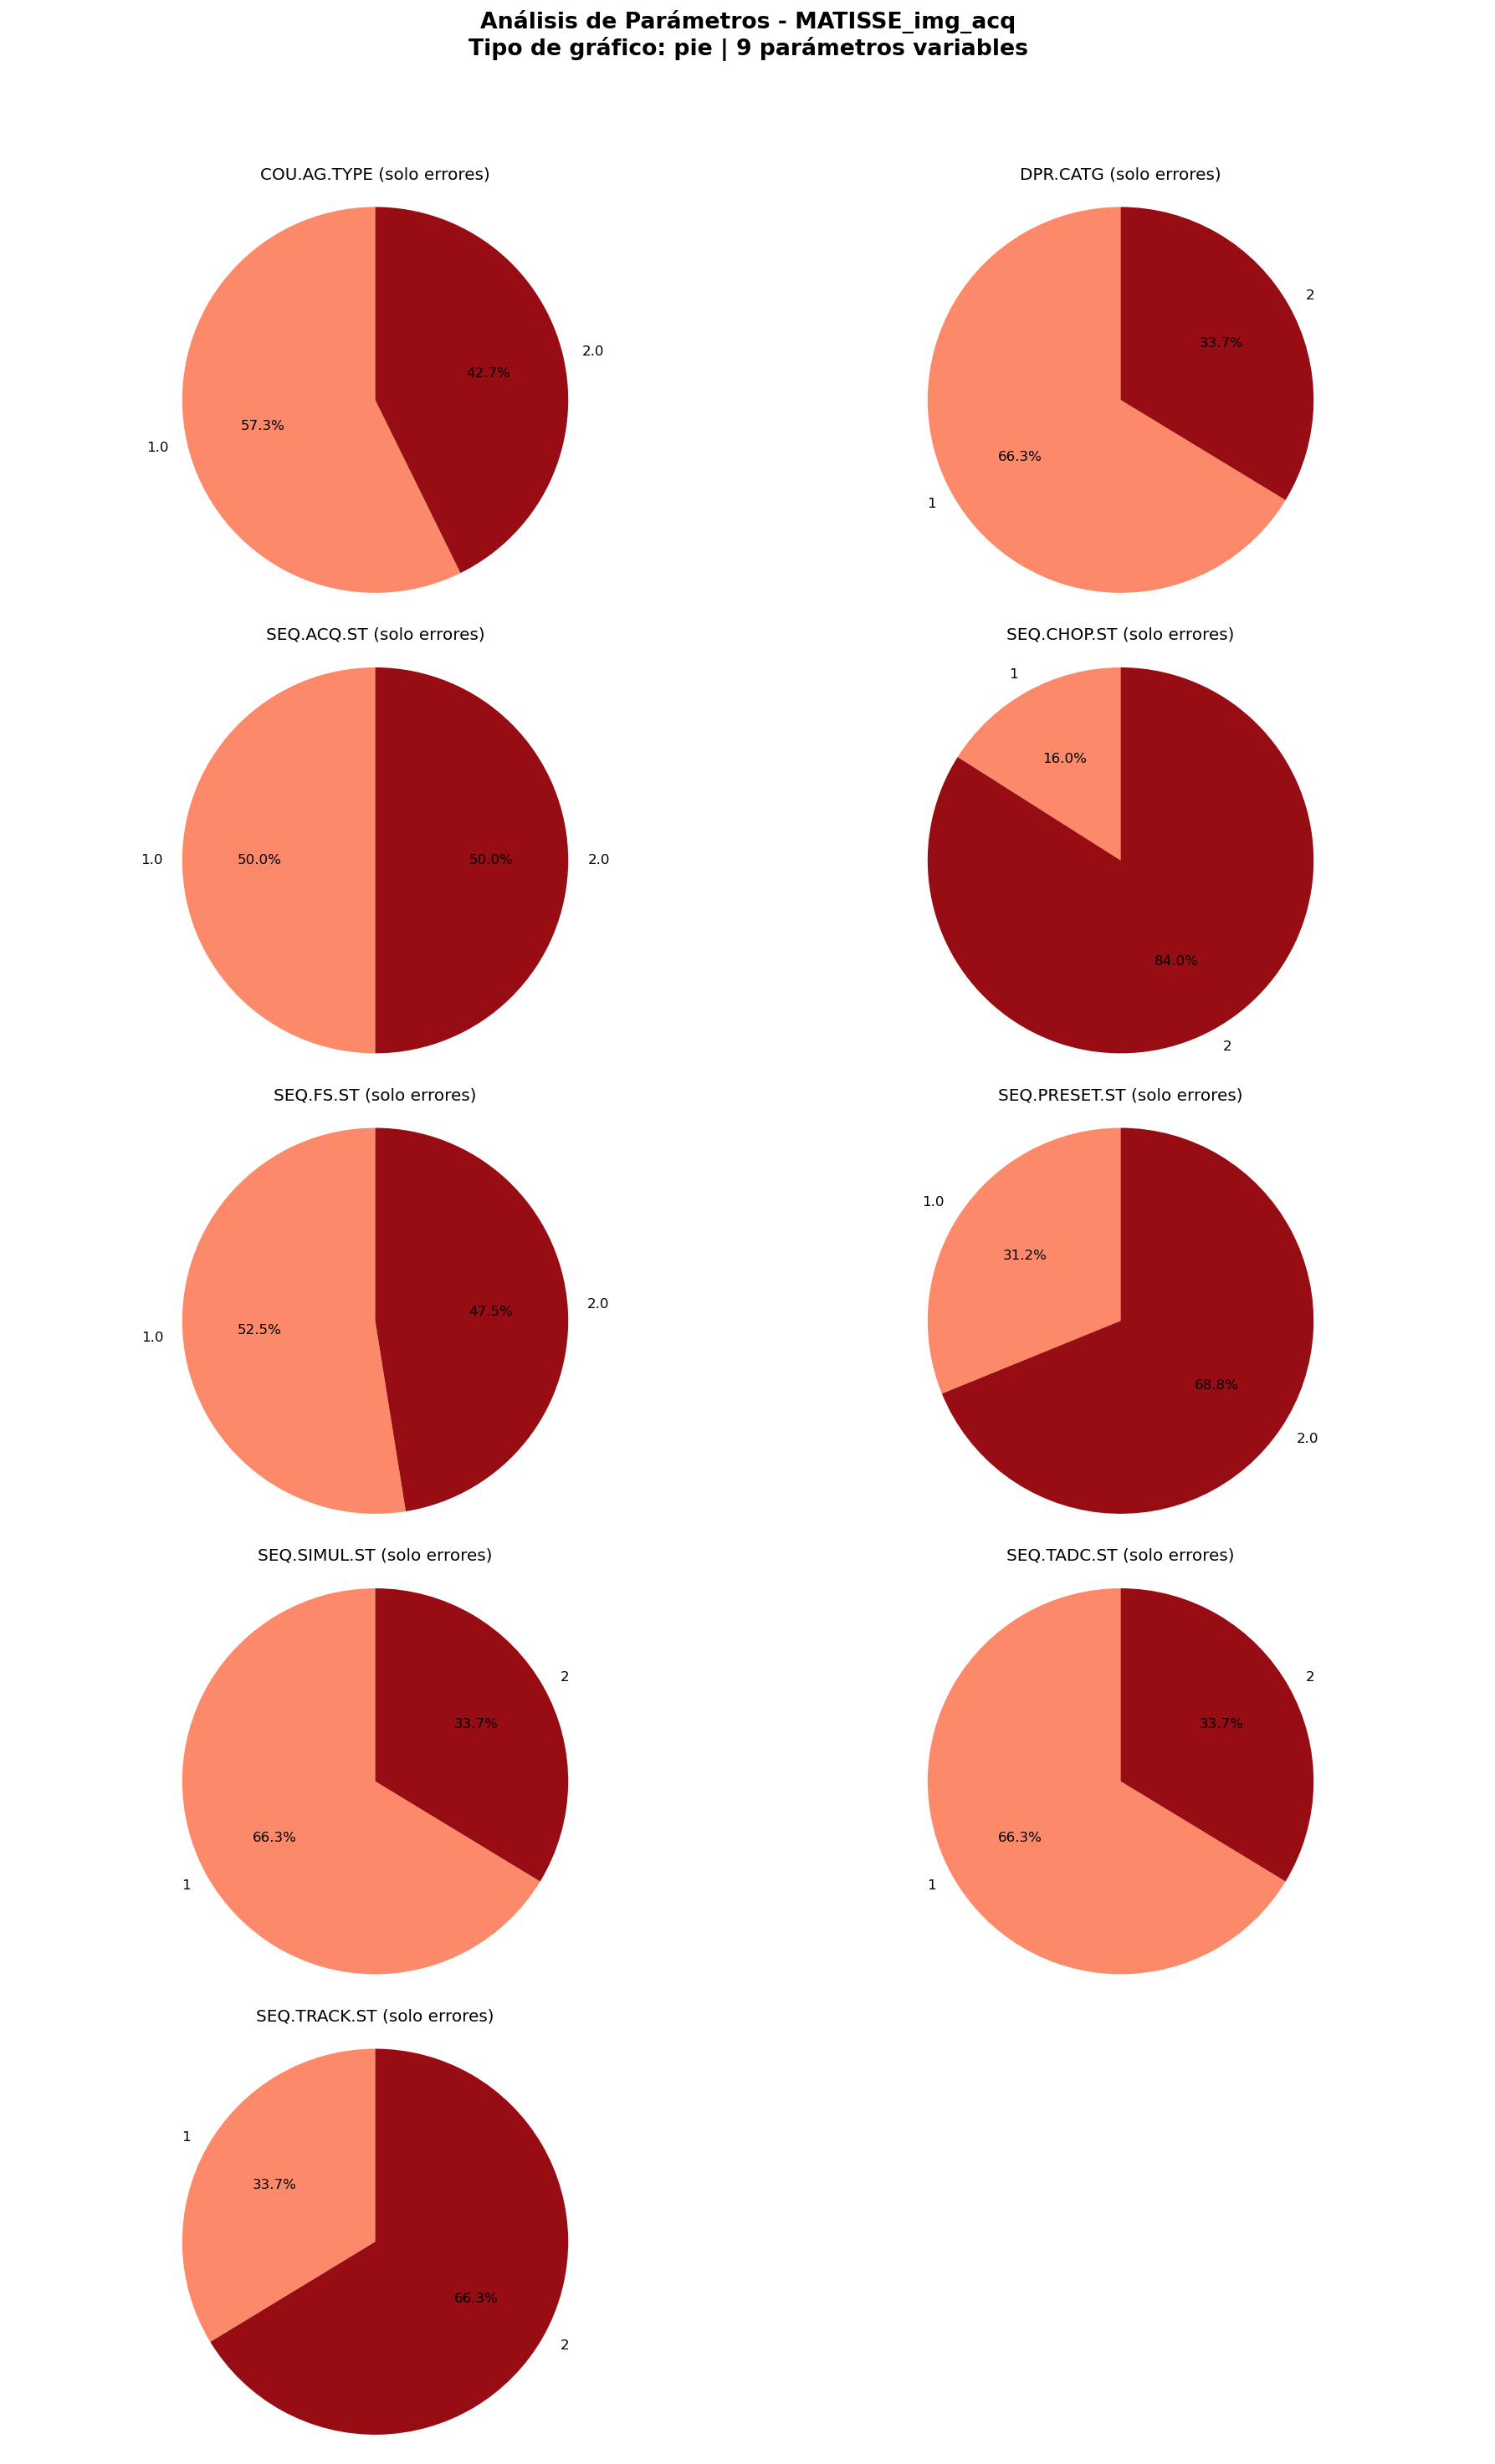

PIE guardado: figuras/MATISSE_img_acq_pie.png
Creando gráficos tipo 'pie' para 7 parámetros NO constantes...
Parámetros constantes (omitidos): ['DET1.APOTYPE.VAL', 'DET1.APOX.VAL', 'DET1.APOY.VAL', 'DET1.DIT', 'DET1.INTERFX.VAL', 'DET1.INTERFY.VAL', 'DET1.NCOHERENT.VAL', 'DET1.NDIT', 'DET1.NINCOHERENT.VAL', 'DET1.SNRLIMIT.VAL', 'DET1.WLMAXCUT.VAL', 'DET1.WLMINCUT.VAL', 'DET2.APOTYPE.VAL', 'DET2.APOX.VAL', 'DET2.APOY.VAL', 'DET2.DIT', 'DET2.INTERFX.VAL', 'DET2.INTERFY.VAL', 'DET2.NCOHERENT.VAL', 'DET2.NDIT', 'DET2.NINCOHERENT.VAL', 'DET2.READ.CURNAME', 'DET2.SNRLIMIT.VAL', 'DET2.WLMAXCUT.VAL', 'DET2.WLMINCUT.VAL', 'DPR.CATG', 'DPR.TECH', 'INS.FIN.NAME', 'INS.PIL.NAME', 'INS.POL.NAME', 'INS.PON.NAME', 'SEQ.DIL.WL0']
Figura guardada en: figuras/errseverity_pie.png


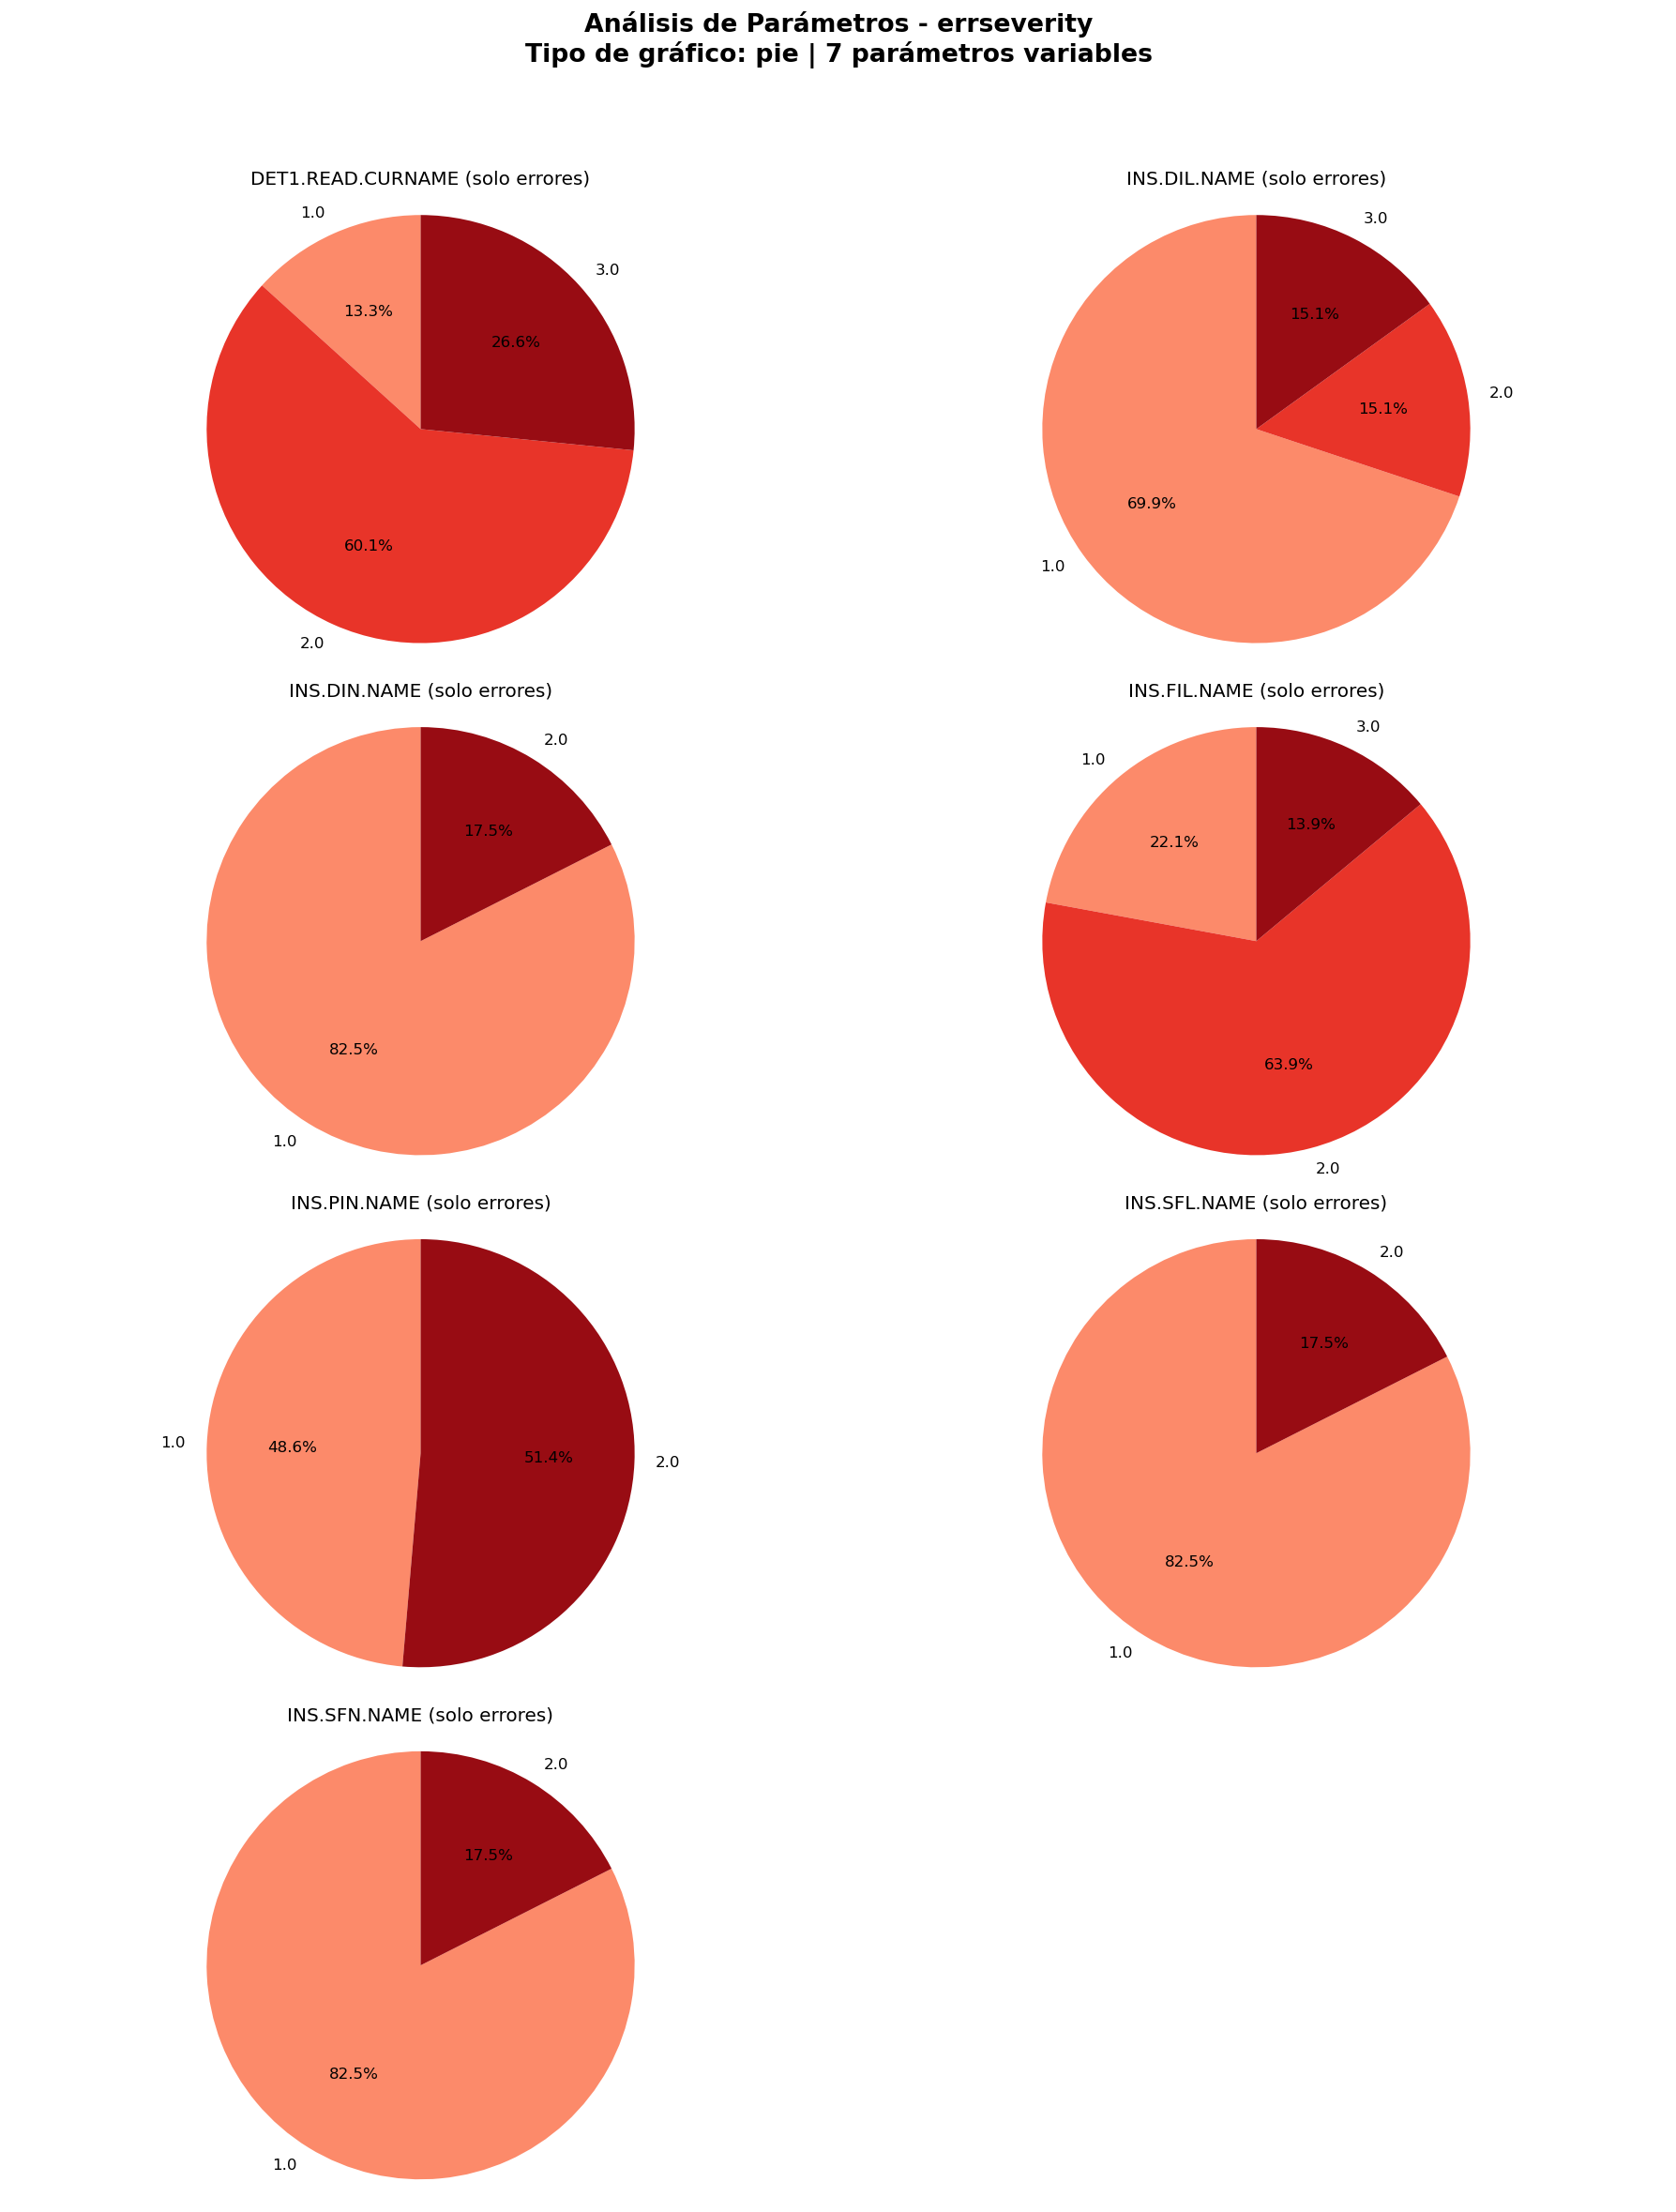

PIE guardado: figuras/errseverity_pie.png


In [12]:
THRESHOLD_NAN = 0.5
CARPETA_FIG = "figuras"

for tpl_id_str in tpl_ids_validos:
    df_err_codified = codified_strval_err_dfs.get(tpl_id_str)

    if df_err_codified is None or df_err_codified.empty:
        print(f"{tpl_id_str}: DataFrame vacío o inexistente. Se omite PIE.")
        continue

    df_err_cleaned = df_err_codified.loc[:, df_err_codified.isna().mean() < THRESHOLD_NAN]
    df_err_cleaned = df_err_cleaned.loc[df_err_cleaned.isna().mean(axis=1) < THRESHOLD_NAN, :]

    if df_err_cleaned.empty:
        print(f"{tpl_id_str}: DataFrame vacío después de la limpieza. Se omite PIE.")
        continue

    columns = sorted(df_err_cleaned.columns)
    if not columns:
        print(f"{tpl_id_str}: No hay columnas válidas después de la limpieza (PIE).")
        continue

    ruta_png = f"{CARPETA_FIG}/{tpl_id_str}_pie.png"

    graficos_por_columna(
        df_sin_error=None,
        df_con_error=df_err_cleaned[columns],
        nombre_archivo=tpl_id_str,
        tipo="pie",
        use_log=True,
        save_path=ruta_png,
        mostrar=True,
    )

    print(f"PIE guardado: {ruta_png}")




## Clustering de observaciones con error (DBSCAN)

Para cada `TPL_ID` con al menos 25 observaciones con error se aplica el
algoritmo DBSCAN sobre los parámetros numéricos normalizados.  
Este proceso permite identificar diferentes **tipos de error** dentro del
mismo `TPL_ID`.

Flujo utilizado:

1. Imputación de valores faltantes (mediana).  
2. Normalización de parámetros (StandardScaler).  
3. DBSCAN en el espacio completo de parámetros.  
4. PCA con 2 componentes para fines de visualización.  
5. *Jitter* sobre las coordenadas para evitar superposición de puntos.

Los puntos con etiqueta `-1` corresponden a observaciones consideradas
**ruido** por DBSCAN (no pertenecen a ningún cluster denso).



Clustering (solo errores) → MATISSE_gen_tec_ali
DBSCAN params: {'eps': np.float64(0.8046162028110425), 'min_samples': 6, 'n': 67, 'p': 8}
Conteo de clusters:
cluster
 0    42
 2    15
 1     7
-1     3
Name: count, dtype: int64
Cluster guardado en: figuras/MATISSE_gen_tec_ali_cluster.png


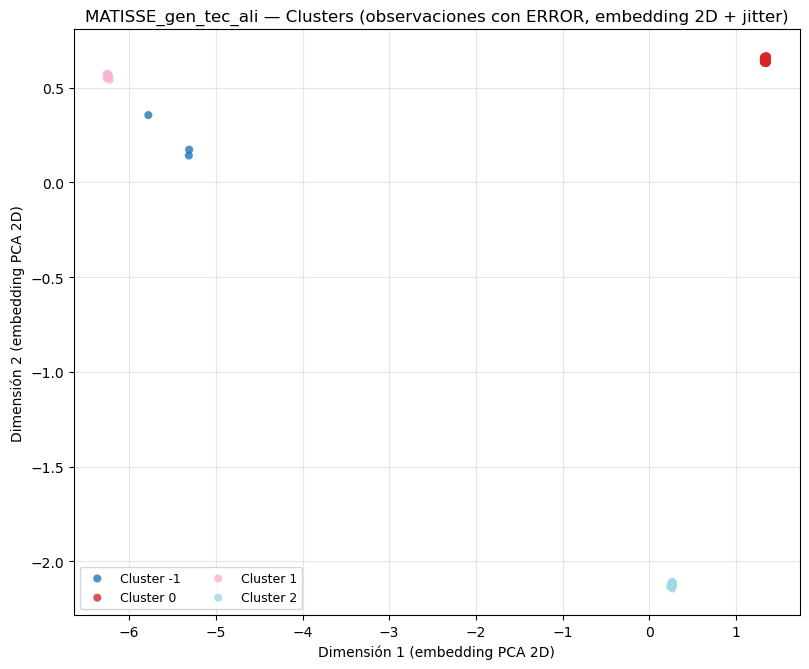

CLUSTER guardado: figuras/MATISSE_gen_tec_ali_cluster.png

Clustering (solo errores) → MATISSE_hyb_obs
DBSCAN params: {'eps': np.float64(1.5493677514902575), 'min_samples': 5, 'n': 43, 'p': 11}
Conteo de clusters:
cluster
 1    21
 0    12
-1    10
Name: count, dtype: int64
Cluster guardado en: figuras/MATISSE_hyb_obs_cluster.png


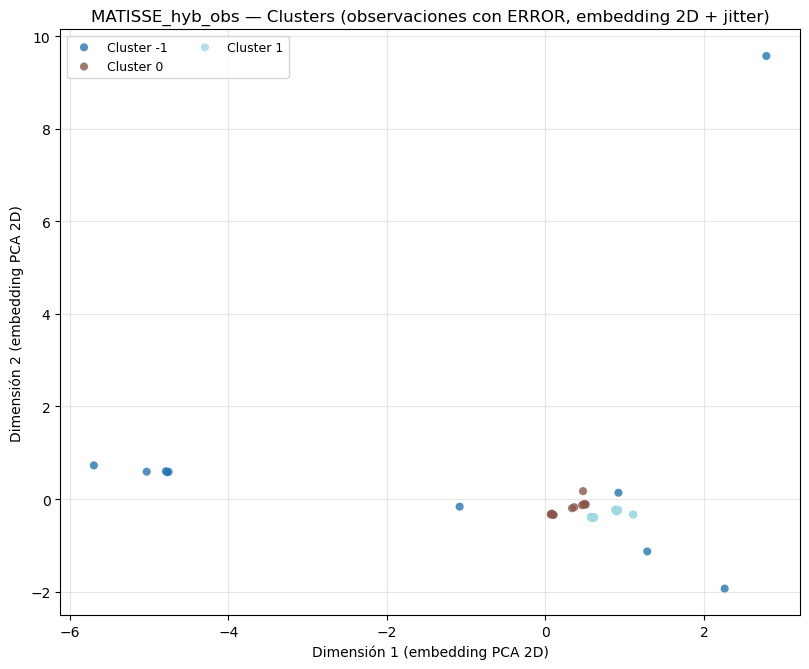

CLUSTER guardado: figuras/MATISSE_hyb_obs_cluster.png

Clustering (solo errores) → MATISSE_img_acq
DBSCAN params: {'eps': np.float64(1.241936439484371), 'min_samples': 5, 'n': 38, 'p': 12}
Conteo de clusters:
cluster
-1    38
Name: count, dtype: int64
Cluster guardado en: figuras/MATISSE_img_acq_cluster.png


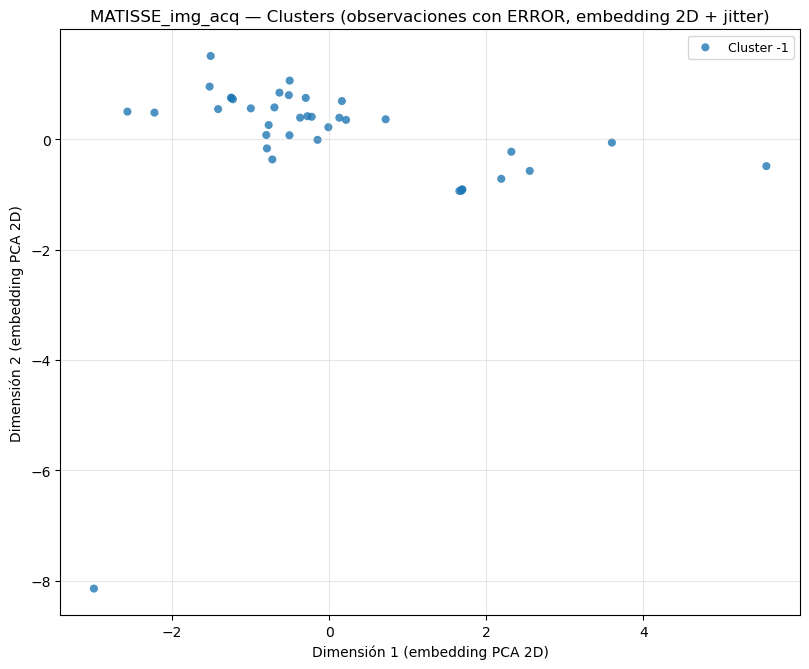

CLUSTER guardado: figuras/MATISSE_img_acq_cluster.png

Clustering (solo errores) → errseverity
DBSCAN params: {'eps': np.float64(1.2105124079973046), 'min_samples': 4, 'n': 26, 'p': 4}
Conteo de clusters:
cluster
 0    21
-1     5
Name: count, dtype: int64
Cluster guardado en: figuras/errseverity_cluster.png


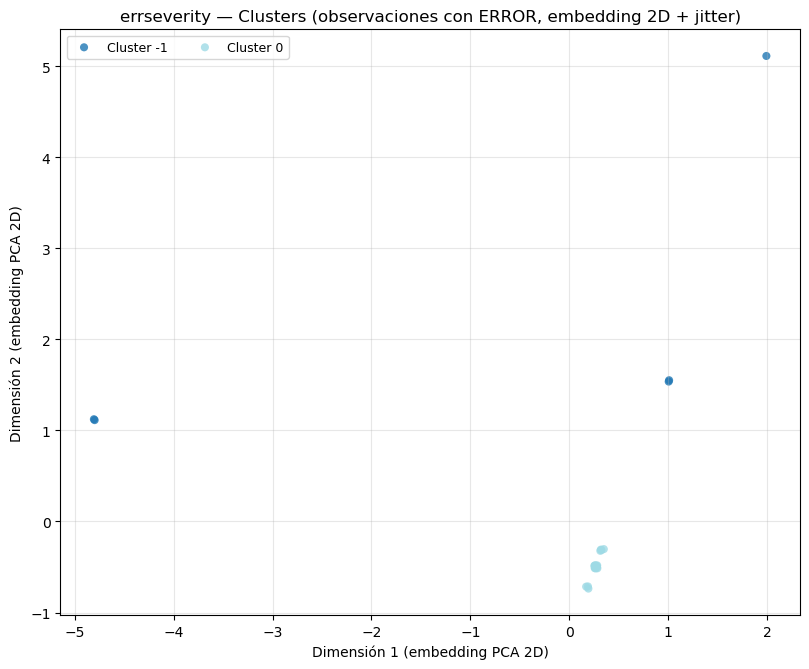

CLUSTER guardado: figuras/errseverity_cluster.png


In [13]:
CARPETA_FIG = "figuras"

for tpl in tpl_ids_validos:
    df_err = tpl_params_dict_err.get(tpl)

    if df_err is None or df_err.empty:
        print(f"{tpl}: DataFrame vacío. Se omite CLUSTER.")
        continue

    print(f"\nClustering (solo errores) → {tpl}")
    df_res, dbp = cluster_todos_en_conjunto(None, df_err)

    if df_res.empty:
        print(f"{tpl}: sin datos utilizables después de la limpieza. Se omite CLUSTER.")
        continue

    print("DBSCAN params:", dbp)
    print("Conteo de clusters:")
    print(df_res["cluster"].value_counts())

    ruta_png = f"{CARPETA_FIG}/{tpl}_cluster.png"

    plot_clusters_por_cluster_y_origen(
        df_res,
        titulo=f"{tpl} — Clusters (observaciones con ERROR, embedding 2D + jitter)",
        jitter=0.02,
        save_path=ruta_png,
        mostrar=True,
    )

    print(f"CLUSTER guardado: {ruta_png}")

